# Import Libraries

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn.tree import plot_tre
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix
from graphviz import Digraph

# Prepare Dataset

## Download and Extract the Dataset

In [2]:
# dataset link: https://data.mendeley.com/datasets/hxsnvwty3r/1

# Defining the dataset URL and output file name
DATASET_URL = "https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/hxsnvwty3r-1.zip"
OUTPUT_FILE = "mango_leaf_bd_dataset.zip"

# Checking if the file already exists to avoid re-downloading
if not os.path.exists(OUTPUT_FILE):
    # Downloading the dataset using curl
    os.system(f"curl -o {OUTPUT_FILE} {DATASET_URL}")
    print(f"Dataset downloaded successfully and saved as '{OUTPUT_FILE}'.")
else:
    print(f"'{OUTPUT_FILE}' already exists. Skipping download.")


Dataset downloaded successfully and saved as 'mango_leaf_bd_dataset.zip'.


In [3]:
!unzip /content/mango_leaf_bd_dataset.zip
# rename the extracted directory
!mv MangoLeafBD\ Dataset mango_leaf_bd_dataset

Archive:  /content/mango_leaf_bd_dataset.zip
  inflating: MangoLeafBD Dataset/Anthracnose/20211008_124249 (Custom).jpg  
  inflating: MangoLeafBD Dataset/Anthracnose/20211008_124306 (Custom).jpg  
  inflating: MangoLeafBD Dataset/Anthracnose/20211008_124253 (Custom).jpg  
  inflating: MangoLeafBD Dataset/Anthracnose/20211008_124252 (Custom).jpg  
  inflating: MangoLeafBD Dataset/Anthracnose/20211008_124250 (Custom).jpg  
  inflating: MangoLeafBD Dataset/Anthracnose/20211008_124302 (Custom).jpg  
  inflating: MangoLeafBD Dataset/Anthracnose/20211008_124301 (Custom).jpg  
  inflating: MangoLeafBD Dataset/Anthracnose/20211008_124256 (Custom).jpg  
  inflating: MangoLeafBD Dataset/Anthracnose/20211008_124310 (Custom).jpg  
  inflating: MangoLeafBD Dataset/Anthracnose/20211008_124312 (Custom).jpg  
  inflating: MangoLeafBD Dataset/Anthracnose/20211008_124305 (Custom).jpg  
  inflating: MangoLeafBD Dataset/Anthracnose/20211008_124334 (Custom).jpg  
  inflating: MangoLeafBD Dataset/Anthracnos

## Flatten the Images

In [4]:
def prepare_dataset(dataset_path: str, target_size: tuple):
    # for image pixel values
    data = []
    # for disease names (labels)
    labels = []

    # loop through each disease folder and process images
    for folder_name in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder_name)

        # check if it's a directory
        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                image_path = os.path.join(folder_path, filename)

                # load the image
                #img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # load as grayscale to reduce dimensions
                img = cv2.imread(image_path)

                # resize all images to `target_size`
                img = cv2.resize(img, target_size)

                # flatten the image and add to the data list
                img_flat = img.flatten()
                data.append(img_flat)

                # add the directory name as the label
                labels.append(folder_name)

    return data, labels

## Create a DataFrame and Display



In [5]:
# define path to the dataset
dataset_path = '/content/mango_leaf_bd_dataset'

# resize all images to 120x160
# or else colab runtime's ram limit will exceed
data, labels = prepare_dataset(dataset_path, (120, 160))

In [6]:
# convert to a dataframe
df = pd.DataFrame(data)
# add labels as a column
df['label'] = labels

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Columns: 57601 entries, 0 to label
dtypes: object(1), uint8(57600)
memory usage: 219.8+ MB


In [8]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,57590,57591,57592,57593,57594,57595,57596,57597,57598,57599
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,...,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,210.221500,205.316000,200.835750,210.834000,205.891250,201.336250,211.127500,206.087750,201.415250,211.302750,...,178.715500,190.771500,183.059000,178.735750,190.846500,183.129250,178.850000,190.526000,182.773500,178.524500
std,43.599079,35.879465,36.831385,42.740322,35.061442,36.223538,42.017629,34.322945,35.807393,41.636384,...,42.532109,42.880246,38.894135,42.831011,43.055352,39.335504,43.240796,43.336455,39.846946,43.742499
min,1.000000,4.000000,2.000000,1.000000,4.000000,2.000000,2.000000,5.000000,3.000000,1.000000,...,1.000000,0.000000,3.000000,1.000000,0.000000,3.000000,1.000000,0.000000,3.000000,1.000000
25%,200.000000,196.000000,185.000000,200.000000,197.000000,185.000000,200.750000,197.000000,185.000000,201.000000,...,147.000000,174.000000,159.000000,147.000000,174.000000,159.000000,148.000000,174.000000,159.000000,147.000000
50%,224.000000,211.000000,206.000000,224.000000,211.000000,206.000000,224.000000,211.000000,206.000000,224.000000,...,181.000000,198.000000,182.500000,181.000000,198.000000,183.000000,181.000000,198.000000,183.000000,181.000000
75%,235.000000,227.000000,227.000000,235.000000,228.000000,227.000000,234.000000,228.000000,227.000000,234.000000,...,212.000000,218.000000,211.000000,213.000000,218.000000,212.000000,213.000000,218.000000,212.000000,213.000000
max,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


In [9]:
print(f"DataFrame Shape:\n{df.shape}")

DataFrame Shape:
(4000, 57601)


In [10]:
df

,0,1,2,3,4,5,6,7,8,9,...,57591,57592,57593,57594,57595,57596,57597,57598,57599,label
0,233,209,181,233,209,181,232,208,180,231,...,198,156,119,198,156,119,198,156,119,Cutting Weevil
1,233,212,191,233,212,191,233,212,191,233,...,197,160,132,196,159,131,195,158,130,Cutting Weevil
2,233,221,221,233,221,221,232,220,220,232,...,193,167,160,193,167,160,192,166,159,Cutting Weevil
3,75,135,108,84,138,113,85,128,102,124,...,191,152,120,191,152,120,190,150,121,Cutting Weevil
4,228,205,179,227,204,178,228,205,179,228,...,191,150,117,191,150,117,191,150,117,Cutting Weevil
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,232,208,186,233,209,187,233,209,187,233,...,203,168,142,202,167,141,203,168,142,Die Back
3996,227,205,193,227,205,193,227,205,193,227,...,206,178,167,206,178,167,206,178,167,Die Back
3997,230,213,210,228,211,208,229,212,209,229,...,201,182,179,200,181,178,200,181,178,Die Back
3998,231,213,206,230,212,205,230,212,205,229,...,176,146,135,175,145,134,175,145,134,Die Back


##  Class Distribution

<ipython-input-11-fee996576388>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='label', palette='viridis')


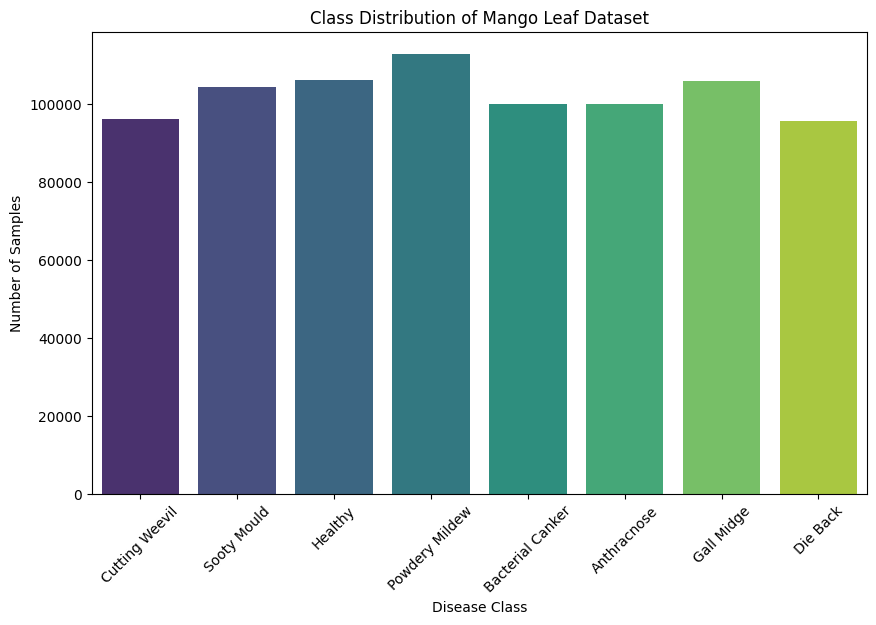

In [11]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='label', palette='viridis')
plt.title("Class Distribution of Mango Leaf Dataset")
plt.xlabel("Disease Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.show()

## Split the Dataset

In [12]:
# define the features and the label
y = df['label']
X = df.drop('label', axis=1)

# do a strified split on the data with 80% train and 20% test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Decision Tree

In [13]:
# create a decision tree classifier with "entropy" criterion
#dt = tree.DecisionTreeClassifier(criterion='entropy', max_depth=8, random_state=42)
dt = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)

# fit the model on the train data
dt.fit(X_train, y_train)

# make predictions on the test data
y_pred_dt = dt.predict(X_test)

Accuracy: 0.67
Precision: 0.67
Recall: 0.67
F1-score: 0.67
Classification Report:
                   precision    recall  f1-score   support

     Anthracnose       0.70      0.71      0.70       100
Bacterial Canker       0.75      0.77      0.76       100
  Cutting Weevil       0.92      0.94      0.93       100
        Die Back       0.81      0.79      0.80       100
      Gall Midge       0.51      0.50      0.50       100
         Healthy       0.56      0.57      0.57       100
  Powdery Mildew       0.60      0.63      0.61       100
     Sooty Mould       0.48      0.44      0.46       100

        accuracy                           0.67       800
       macro avg       0.67      0.67      0.67       800
    weighted avg       0.67      0.67      0.67       800



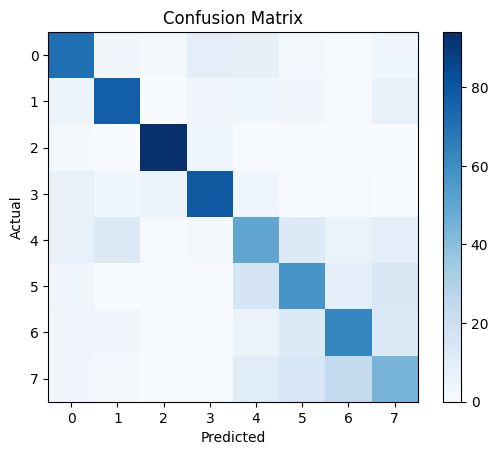

In [14]:
# calculate the accuracy, precision, recall, and f1-score
dt_acc = accuracy_score(y_test, y_pred_dt)
dt_prec = precision_score(y_test, y_pred_dt, average='macro')
dt_rec = recall_score(y_test, y_pred_dt, average='macro')
dt_f1 = f1_score(y_test, y_pred_dt, average='macro')
dt_report = classification_report(y_test, y_pred_dt)

# print the results
print(f"Accuracy: {dt_acc:.2f}")
print(f"Precision: {dt_prec:.2f}")
print(f"Recall: {dt_rec:.2f}")
print(f"F1-score: {dt_f1:.2f}")
# print the classification report
print("Classification Report:\n", dt_report)

# plot the confusion matrix
dt_cm = confusion_matrix(y_test, y_pred_dt)

plt.imshow(dt_cm, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.colorbar()
plt.show()

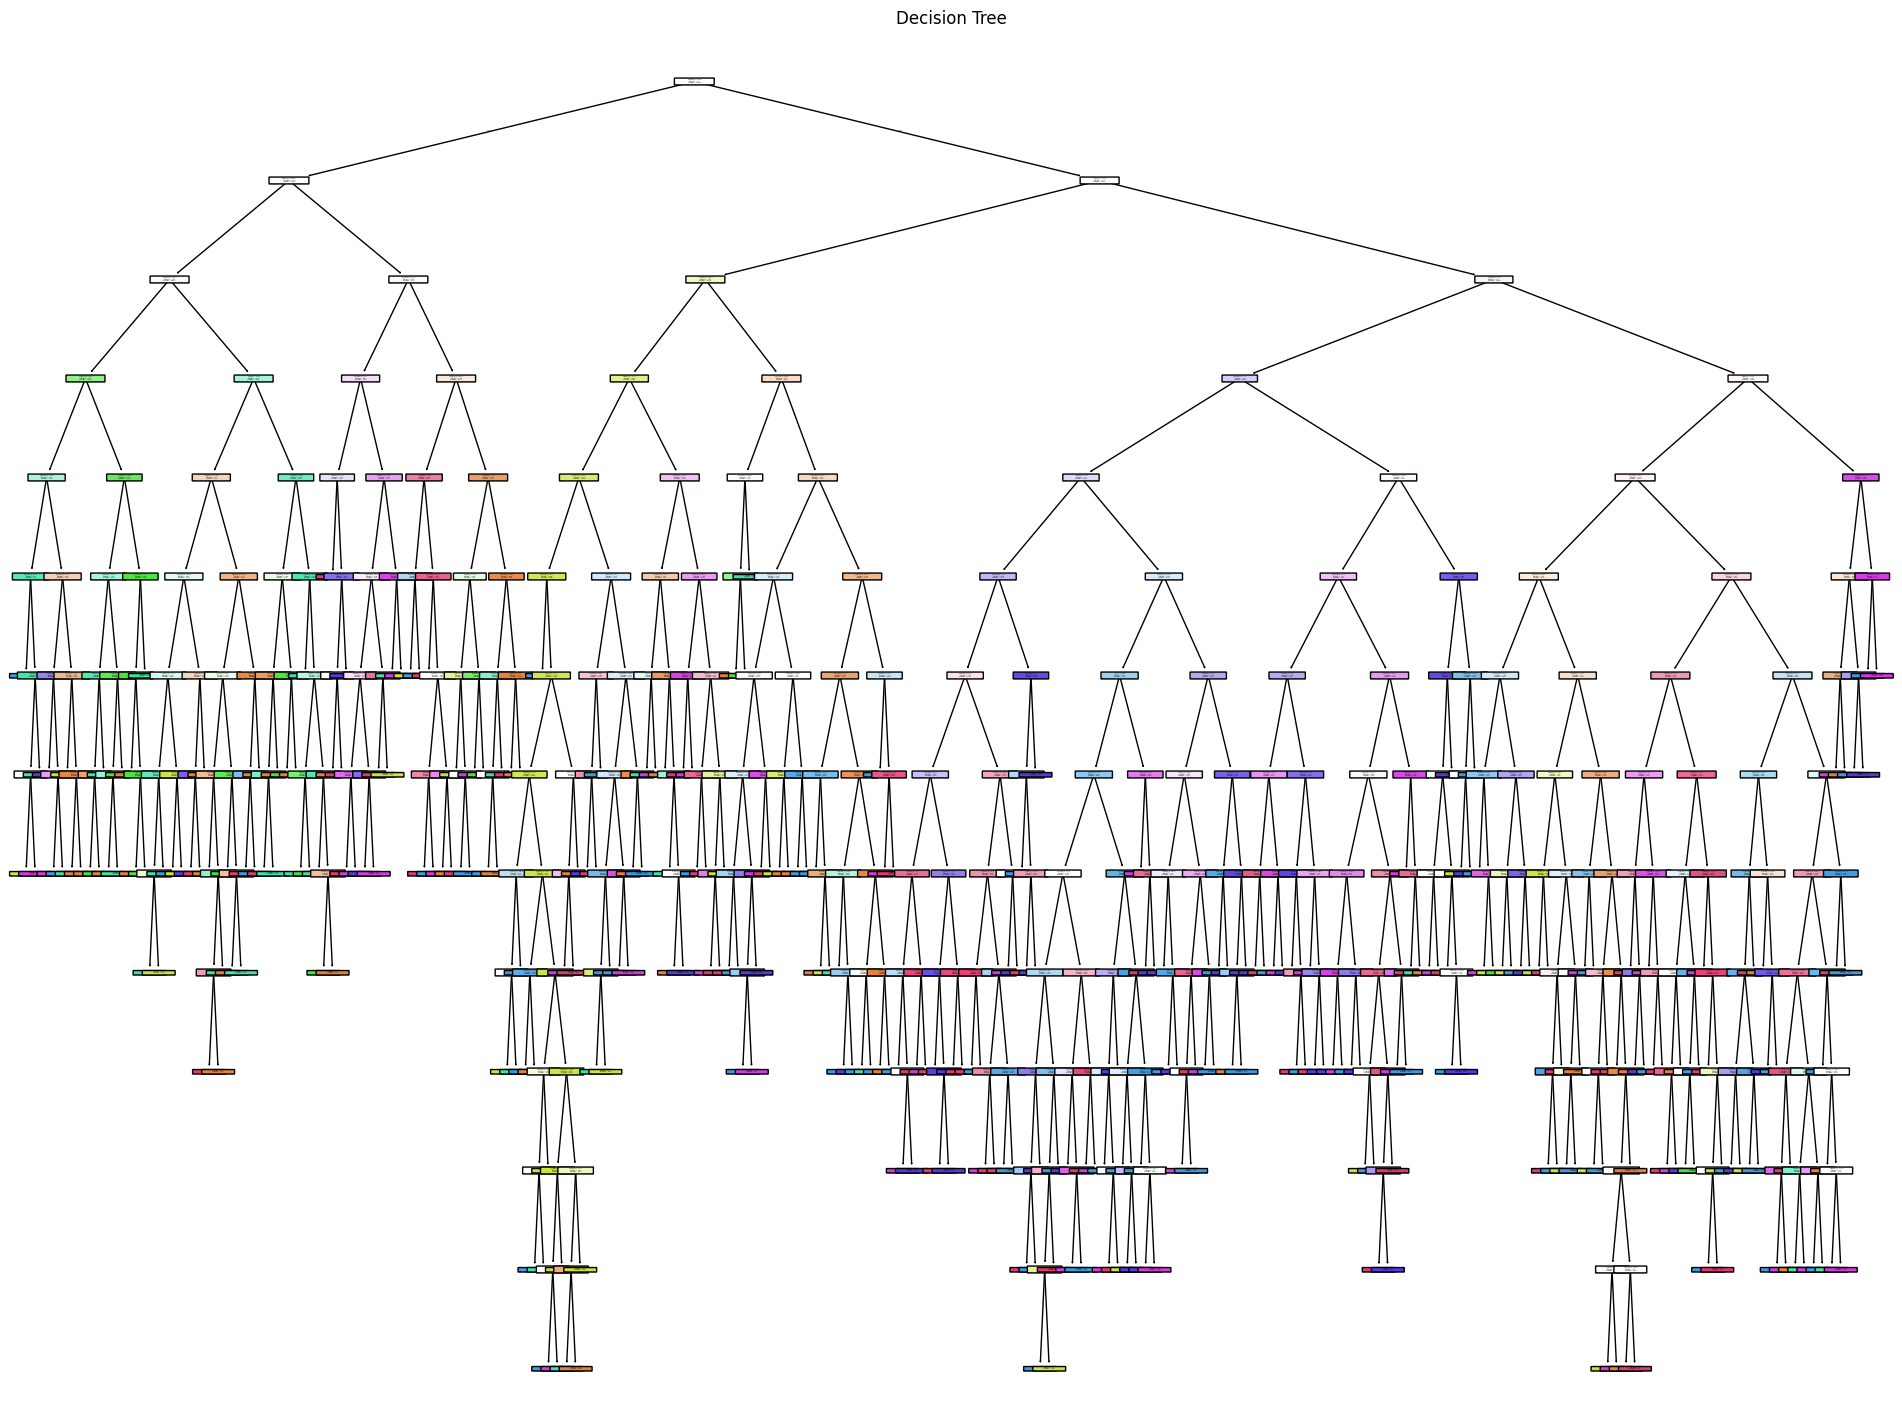

In [20]:
# Plot the decision tree
plt.figure(figsize=(24, 18))
plot_tree(dt,
          filled=True,
          rounded=True,
          proportion=True,
          precision=2)
plt.title('Decision Tree')
plt.show()

# Random Forest

In [21]:
# create a random forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# train the model
rf_classifier.fit(X_train, y_train)

# make predictions
y_pred_rf = rf_classifier.predict(X_test)

In [22]:
# evaluate performance
rf_acc = accuracy_score(y_test, y_pred_rf)
rf_prec = precision_score(y_test, y_pred_rf, average='macro')
rf_rec = recall_score(y_test, y_pred_rf, average='macro')
rf_f1 = f1_score(y_test, y_pred_rf, average='macro')
rf_report = classification_report(y_test, y_pred_rf)

# print the results
print(f"Accuracy: {rf_acc:.2f}")
print(f"Precision: {rf_prec:.2f}")
print(f"Recall: {rf_rec:.2f}")
print(f"F1-score: {rf_f1:.2f}")
# print the classification report
print("Classification Report:\n", rf_report)


Accuracy: 0.87
Precision: 0.88
Recall: 0.87
F1-score: 0.87
Classification Report:
                   precision    recall  f1-score   support

     Anthracnose       0.90      0.89      0.89       100
Bacterial Canker       0.83      0.95      0.89       100
  Cutting Weevil       0.97      1.00      0.99       100
        Die Back       0.97      0.89      0.93       100
      Gall Midge       0.73      0.76      0.75       100
         Healthy       0.83      0.85      0.84       100
  Powdery Mildew       0.92      0.85      0.89       100
     Sooty Mould       0.85      0.80      0.82       100

        accuracy                           0.87       800
       macro avg       0.88      0.87      0.87       800
    weighted avg       0.88      0.87      0.87       800



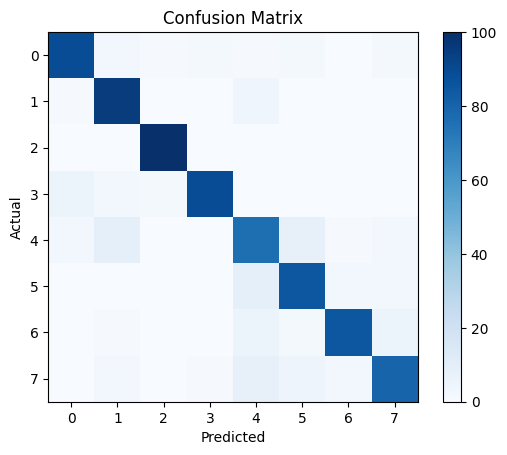

In [23]:
# plot the confusion matrix
rf_cm = confusion_matrix(y_test, y_pred_rf)

plt.imshow(rf_cm, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.colorbar()
plt.show()

### Plot the tree

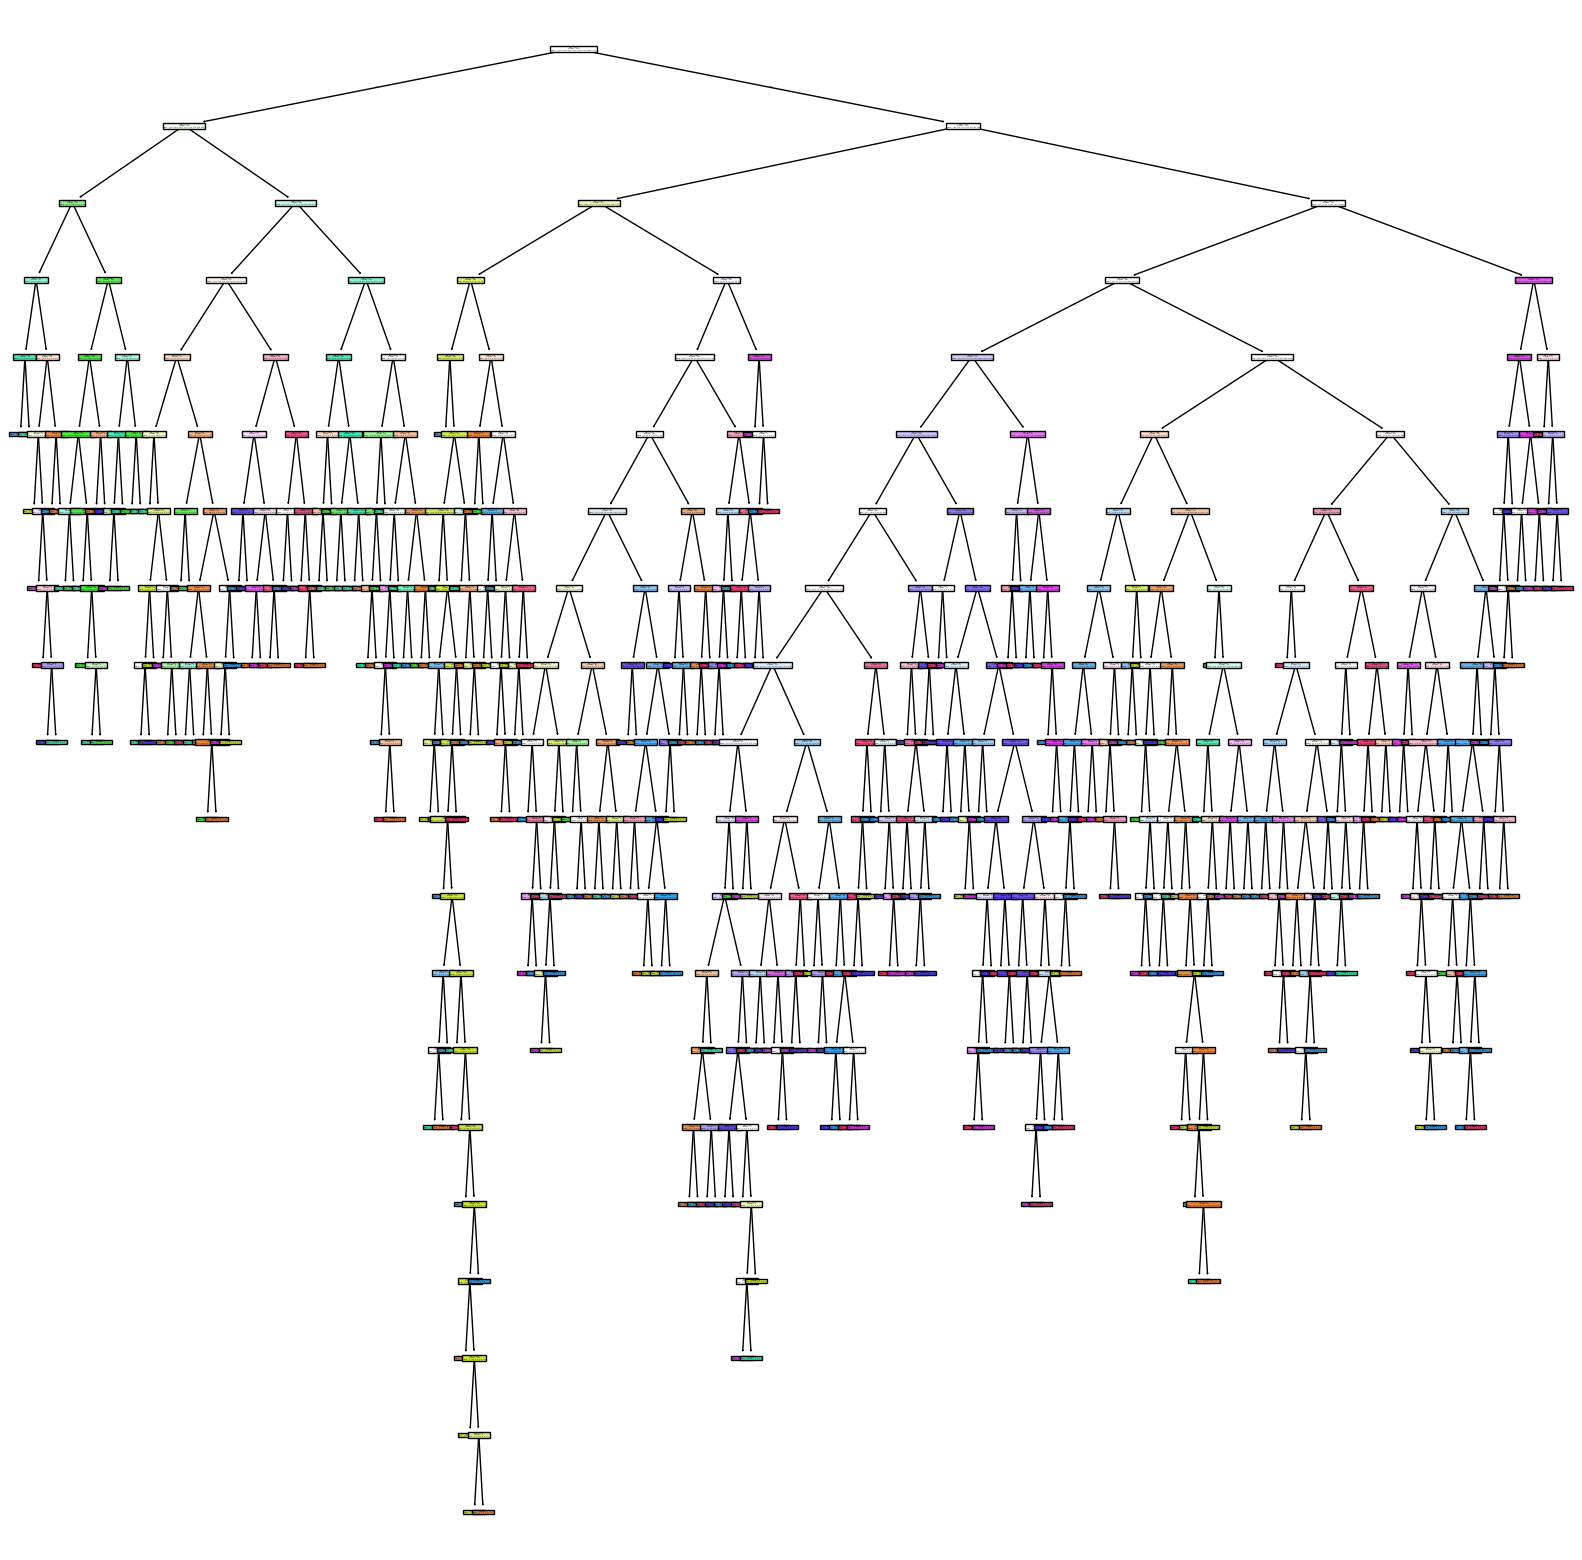

In [24]:
plt.figure(figsize=(20, 20))
tree.plot_tree(rf_classifier.estimators_[0], feature_names=X.columns, filled=True)
plt.show()